In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
import copy

import matplotlib.pyplot as plt
from tqdm import tqdm

data_root = "/content/data/Garbage_Dataset_Classification/images"

'''
이미지 사이즈를 224로 정하는 이유:
기본 데이터셋의 이미지 크기는 256 * 256 픽셀임.
이미지 사이즈를 살짝 작은 224 픽셀로 하였을 때
축소되는 사이즈가 크지 않아 중요 정보를 잃지 않으면서,
RandomResizedCrop을 통해 무작위 비율로 자른 이미지에서
모델이 다양한 뷰를 학습하게 할 수 있음. (데이터 증강 효과)
더불어 연산량을 줄이는 효과도 볼 수 있음.
'''
IM_SIZE = 224

# 변환 정의
transform_train = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomResizedCrop(IM_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

transform_eval = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

# 전체 데이터셋 로드, 폴더의 클래스명으로 데이터 라벨링
full_ds = datasets.ImageFolder(data_root, transform=transform_train)
targets = np.array([y for _, y in full_ds])
num_classes = len(full_ds.classes)
print(full_ds.classes, num_classes)

# Train / Val / Test 세트 분리
indices = np.arange(len(full_ds))
train_idx, rest_idx = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=targets
)
rest_targets = targets[rest_idx]
val_idx, test_idx = train_test_split(
    rest_idx, test_size=0.5, random_state=42, stratify=rest_targets
)

# Train 데이터엔 Train 변환 적용, Val / Test에는 eval 변환 적용
train_ds = Subset(full_ds, train_idx)
val_ds = Subset(datasets.ImageFolder(data_root, transform=transform_eval), val_idx)
test_ds = Subset(datasets.ImageFolder(data_root, transform=transform_eval), test_idx)

# DataLoader - Further reduced batch size to address OutOfMemoryError
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] 6


torch.Size([3, 224, 224])


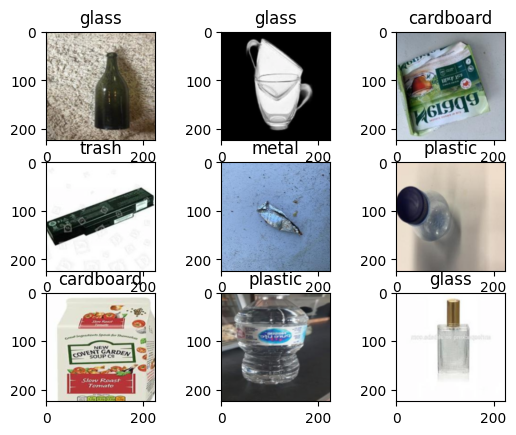

In [3]:
# Helper function to denormalize images
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    return image * std + mean

for i in range(9):
  plt.subplot(3, 3, i+1)
  # Denormalize and display the image
  img = train_ds[i][0].unsqueeze(0) # Add batch dimension for denormalization
  img = denormalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  plt.imshow(img.squeeze(0).permute(1, 2, 0)) # Remove batch dimension and permute

  plt.title(train_ds.dataset.classes[train_ds[i][1]])

# Access the shape of the image tensor, not the tuple
print(train_ds[0][0].shape)
plt.show()

In [4]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(BasicBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.relu = nn.ReLU()

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    return x

class CNN(nn.Module):
    def __init__(self, num_classes): # 클래스의 갯수
        super(CNN, self).__init__()

        self.block1 = BasicBlock(in_channels=3, out_channels=16)
        self.block2 = BasicBlock(in_channels=16, out_channels=32)
        self.block3 = BasicBlock(in_channels=32, out_channels=64)

        # classification을 위한 FC 정의
        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

        self.relu = nn.ReLU()

        # Dropout Layer 추가
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, start_dim=1) # 2차원의 feature map을 1차원으로

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)

        return x

# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, mode='min', restore_best=True):
        """
        patience: 개선이 없다고 판단하기까지 기다릴 epoch 수
        min_delta: 개선으로 인정할 최소 변화량 (손실은 감소, 정확도는 증가)
        mode: 'min' -> 낮을수록 좋음(예: val_loss), 'max' -> 높을수록 좋음(예: val_acc)
        restore_best: 중단 시 최적 가중치로 롤백
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.restore_best = restore_best

        self.best_score = np.inf
        self.counter = 0
        self.best_state = None
        self.should_stop = False

    def step(self, current, model):
        improved = (current < self.best_score - self.min_delta)

        if improved:
            self.best_score = current
            self.counter = 0
            if self.restore_best:
                self.best_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

    def restore(self, model):
        if self.restore_best and self.best_state is not None:
            model.load_state_dict(self.best_state)

In [5]:
# 학습을 진행할 프로세서 설정
device = "cuda" if torch.cuda.is_available() else "cpu"


print(f"device 정보: {device}")

# CNN 모델 정의 - Redefine model after correcting the CNN class
model = CNN(num_classes=6)

# 모델을 device로 보냄
model.to(device)

# Print the model architecture to verify the changes
print(model)

device 정보: cuda
CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_fea

In [6]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# === 하이퍼파라미터 & 준비 ===
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optim = Adam(model.parameters(), lr=lr)

# EarlyStopping 인스턴스 생성 (원하시는 값으로 조정)
early_stopper = EarlyStopping(patience=10, min_delta=0.0, mode='min', restore_best=True)

num_epochs = 100

# 손실 그래프 출력용 리스트
train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(num_epochs):
    # ====== Train ======
    model.train()
    train_loss_sum, train_correct, train_count = 0.0, 0, 0

    for data, label in tqdm(train_loader):
        data, label = data.to(device), label.to(device)

        optim.zero_grad()
        preds = model(data)
        loss = criterion(preds, label)
        loss.backward()
        optim.step()

        train_loss_sum += loss.item() * data.size(0)
        train_correct  += (preds.argmax(1) == label).sum().item()
        train_count    += data.size(0)

    train_loss = train_loss_sum / train_count
    train_acc  = train_correct / train_count
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # ====== Validation ======
    model.eval()
    val_loss_sum, val_correct, val_count = 0.0, 0, 0
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            preds = model(data)
            vloss = criterion(preds, label)
            val_loss_sum += vloss.item() * data.size(0)
            val_correct  += (preds.argmax(1) == label).sum().item()
            val_count    += data.size(0)

    val_loss = val_loss_sum / val_count
    val_acc  = val_correct / val_count
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # 10에폭마다(및 첫 에폭) 로그 출력
    if epoch == 0 or epoch % 10 == 9:
        print(f"[Epoch {epoch+1:03d}] "
              f"train {train_loss:.4f}/{train_acc*100:.1f}% | "
              f"val {val_loss:.4f}/{val_acc*100:.1f}%")

    # ====== Early Stopping 체크(보통 val_loss 기준) ======
    early_stopper.step(val_loss, model)
    if early_stopper.should_stop:
        print(f"Early stopping at epoch {epoch+1}. Best val_loss: {early_stopper.best_score:.4f}")
        early_stopper.restore(model)  # 최적 가중치 복원
        break

# 최종(최적) 가중치 저장
torch.save(model.state_dict(), "model_Garbage_best.pth")


100%|██████████| 348/348 [00:44<00:00,  7.85it/s]


[Epoch 001] train 1.7921/17.7% | val 1.7901/18.0%


100%|██████████| 348/348 [00:44<00:00,  7.86it/s]


[Epoch 010] train 1.2299/54.6% | val 1.1628/56.6%


100%|██████████| 348/348 [00:43<00:00,  7.95it/s]


[Epoch 020] train 0.9015/67.8% | val 0.8876/67.5%


100%|██████████| 348/348 [00:43<00:00,  7.97it/s]


[Epoch 030] train 0.7395/74.2% | val 0.7886/72.8%


100%|██████████| 348/348 [00:42<00:00,  8.11it/s]


[Epoch 040] train 0.6574/76.9% | val 0.7295/75.2%


100%|██████████| 348/348 [00:44<00:00,  7.88it/s]


[Epoch 050] train 0.6041/79.4% | val 0.7222/75.8%


100%|██████████| 348/348 [00:43<00:00,  7.98it/s]


Early stopping at epoch 51. Best val_loss: 0.6990


In [16]:
model.load_state_dict(torch.load("model_Garbage_best.pth", map_location=device))

num_corr = 0

with torch.no_grad():
    for data, label in tqdm(test_loader):
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr

    print(f"Accuracy:{num_corr/len(test_ds)}")

100%|██████████| 44/44 [00:04<00:00, 10.54it/s]

Accuracy:0.7577282530553558


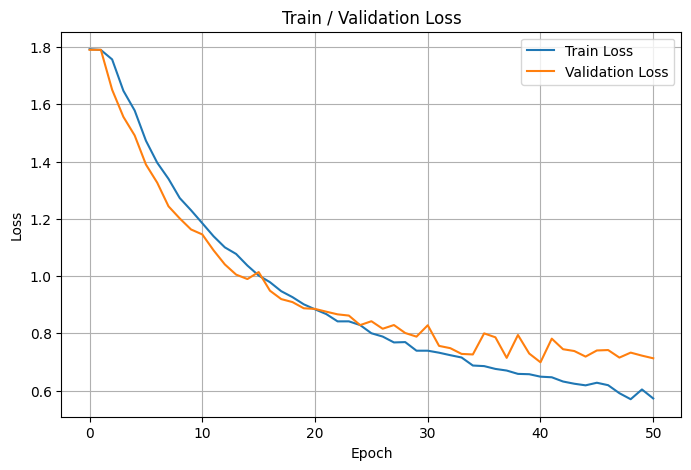

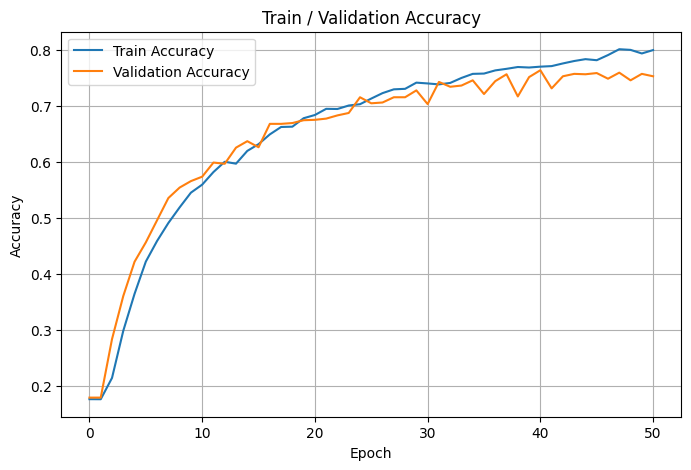

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train / Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
from PIL import Image, ImageOps
from pathlib import Path

@torch.no_grad()
def predict_images(
    inputs,
    model,
    class_names,
    transform,                  # test_tf
    device="cuda" if torch.cuda.is_available() else "cpu",
    batch_size=32,
    topk=1,
    patterns=(".jpg", ".jpeg", ".png"),  # 허용 확장자
):
    """
    다양한 입력을 받아 일괄 예측하고 결과를 리스트(dict)로 반환합니다.
    - inputs: 파일 경로(1장), 파일 경로 리스트, 또는 폴더 경로
    - topk: 상위 k개 클래스도 보고 싶다면 >1로
    - save_csv: CSV 경로 지정 시 결과를 파일로 저장
    """
    # --- 1) 경로 수집 ---
    def collect_paths(x):
        if isinstance(x, (str, Path)):
            p = Path(x)
            if p.is_dir():
                files = [str(f) for f in sorted(p.rglob("*")) if f.suffix.lower() in patterns]
                return files
            else:
                return [str(p)]
        elif isinstance(x, (list, tuple)):
            out = []
            for item in x:
                out.extend(collect_paths(item))
            # 중복 제거 & 정렬
            return sorted(set(out))
        else:
            raise ValueError("inputs는 경로(문자열/Path), 리스트, 혹은 폴더여야 합니다.")

    img_paths = collect_paths(inputs)
    if len(img_paths) == 0:
        print("예측할 이미지가 없습니다.")
        return []

    # --- 2) 모델 평가 모드 ---
    model.eval()

    # --- 3) 배치 처리 ---
    results = []
    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i+n]

    for batch_paths in chunks(img_paths, batch_size):
        batch_tensors = []
        for p in batch_paths:
            img = Image.open(p).convert("RGB")
            if exif_fix:
                img = ImageOps.exif_transpose(img)
            x = transform(img)    # (C,H,W)
            batch_tensors.append(x)
        x = torch.stack(batch_tensors, 0).to(device)   # (B,C,H,W)

        logits = model(x)                                 # (B,num_classes)
        probs  = torch.softmax(logits, dim=1).cpu()       # (B,num_classes)

        if topk == 1:
            top_idx = probs.argmax(dim=1).tolist()
            for i, p in enumerate(batch_paths):
                cls_idx = top_idx[i]
                results.append({
                    "path": p,
                    "pred": class_names[cls_idx],
                    "conf": float(probs[i, cls_idx].item())
                })
        else:
            confs, idxs = torch.topk(probs, k=topk, dim=1)   # (B,topk)
            for i, p in enumerate(batch_paths):
                preds = [(class_names[idxs[i,j].item()], float(confs[i,j].item()))
                         for j in range(topk)]
                results.append({
                    "path": p,
                    "topk": preds
                })

    # Ensure results list is returned
    return results

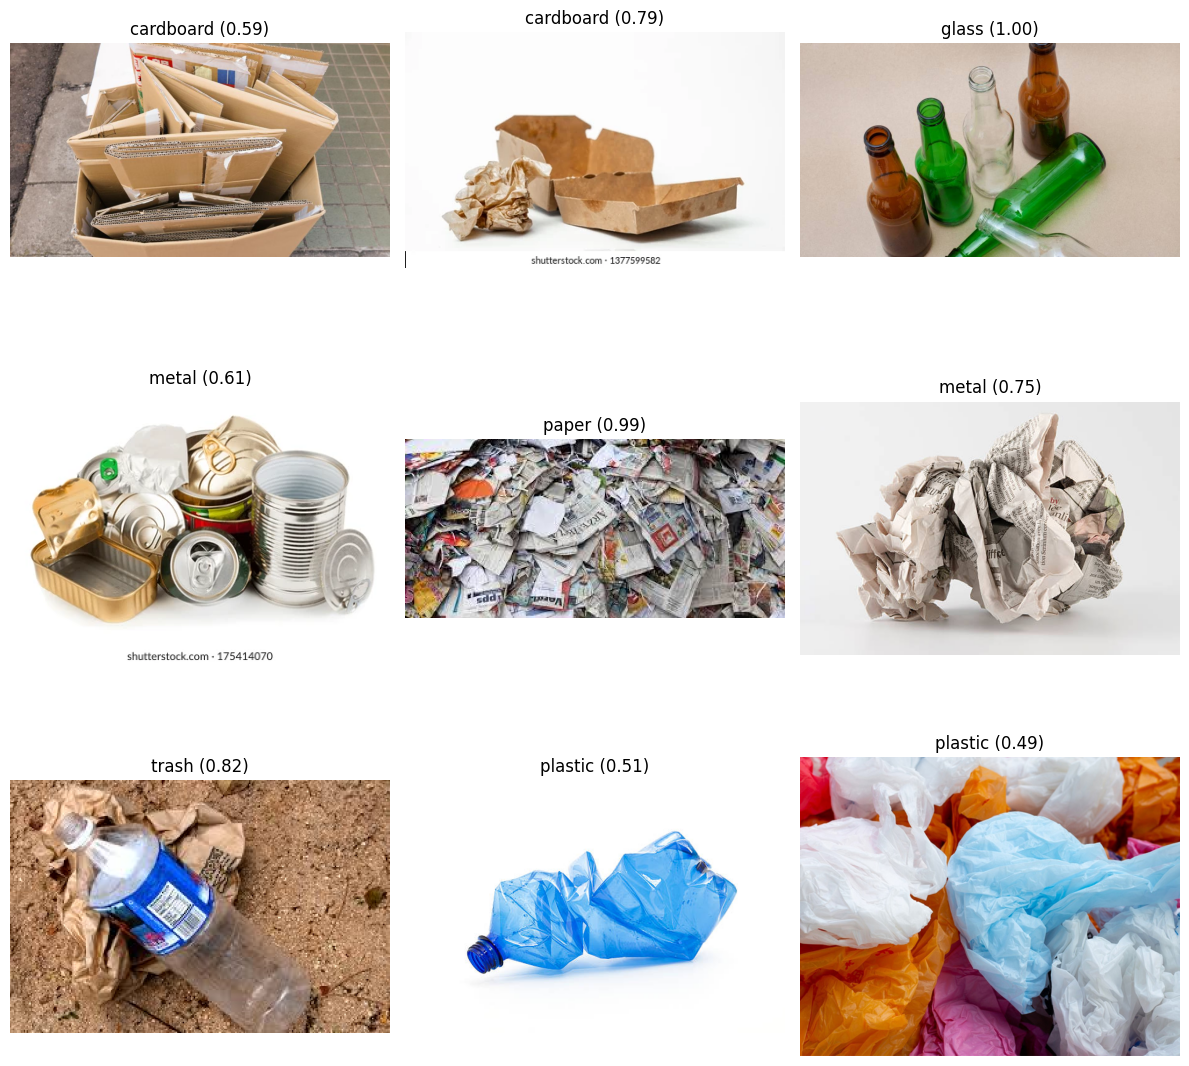

In [32]:
# 예측
out = predict_images(
    "/content/my_photos", model, class_names, test_tf,
    batch_size=9, topk=1
)

# 3x3 그리드 시각화
plt.figure(figsize=(12, 12))
for i, r in enumerate(out[:9]):  # 첫 9장만
    plt.subplot(3, 3, i + 1)
    img = Image.open(r["path"]).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{r['pred']} ({r['conf']:.2f})")
plt.tight_layout()
plt.show()